## Even More pretrained models in PyTorch from OSMR

### Compute and plot average Log Frobenius Norms

$$\langle\log_{10}\Vert\mathbf{W}\Vert^{2}_{F}\rangle$$



https://github.com/osmr/imgclsmob


In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn

import re
import pandas as pd

import numpy as np
import powerlaw

from tqdm import tqdm_notebook as tqdm

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,10]
matplotlib.rcParams.update({'font.size': 24})
marker_size = 75

In [3]:
import pytorchcv

In [4]:
from pytorchcv.model_provider import get_model as ptcv_get_model
import torch
from torch.autograd import Variable

net = ptcv_get_model("resnet18", pretrained=True)


In [5]:
net.modules

<bound method Module.modules of ResNet(
  (features): Sequential(
    (init_block): ResInitBlock(
      (conv): ResConv(
        (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activ): ReLU(inplace)
      )
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (stage1): Sequential(
      (unit1): ResUnit(
        (body): ResBlock(
          (conv1): ResConv(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (activ): ReLU(inplace)
          )
          (conv2): ResConv(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [6]:
type(net)

pytorchcv.models.resnet.ResNet

In [7]:
model = models.resnet18(True)
model.modules()

<generator object Module.modules at 0x122a798e0>

In [8]:
def get_conv2D_Wmats(Wtensor):
    """Extract W slices from a 4 index conv2D tensor of shape: (N,M,i,j) or (M,N,i,j).  Return ij (N x M) matrices"""
    Wmats = []
    s = Wtensor.shape
    N, M, imax, jmax = s[0],s[1],s[2],s[3]
    #print("tensor shape", N,M,imax,jmax)
    for i in range(imax):
        for j in range(jmax):
            W = Wtensor[:,:,i,j]
            if N < M:
                W = W.T
            Wmats.append(W)
    return Wmats

In [9]:
MIN_DIM = 10

def iter_pytorch_layers(model, min_dim=MIN_DIM):
    """Iterate over a pytorch layers and  weight matrix.  
    Supports linear, conv2d, and conv2d-slices"""
    
    nlayers = 0
    for im, m in enumerate(model.modules()):
        #print("######## {}".format(im))
        #print(m)
        if isinstance(m, nn.Linear):
            nlayers += 1
            #$print("  ===> Linear")
            W = np.array(m.weight.data.clone().cpu())
            if W is not None:
                yield W
        elif isinstance(m, nn.Conv2d):
            nlayers += 1
            #$print("  ===> Conv2D")
            Wtensor = np.array(m.weight.data.clone().cpu())
            Wmats = get_conv2D_Wmats(Wtensor)
            for W in Wmats:
                if (np.min(W.shape) >= min_dim):
                    yield W
                    
    print("nlayers {}".format(nlayers))

In [10]:
def num_layers(net):
    cnt = 0
    for W in iter_pytorch_layers(net):
        cnt+=1
    return cnt

In [11]:
!ls  ../imgclsmob/osmr_modelnames 

../imgclsmob/osmr_modelnames


In [12]:
osmr = pd.read_csv("osmr_modelnames", delimiter="\t")

In [13]:
def fixname(modelname):
    fixedname = modelname
    # condensenet
    fixedname = fixedname.replace(' (C=G=4)','_c4_g4')
    fixedname = fixedname.replace(' (C=G=8)','_c8_g8')
    # resnet , mobilenetv2, shuffleney
    fixedname = fixedname.replace(' x0.25','_wd4')
    fixedname = fixedname.replace(' x0.5','_wd2')
    fixedname = fixedname.replace(' x0.75','_w3d4')
    fixedname = fixedname.replace(' x1.0','_w1')
    fixedname = fixedname.replace(' x1.5','_w3d2')

    
    # menet TODO: FIX
    fixedname = fixedname.replace(' (g=','_g')
    # darkent
    fixedname = fixedname.replace(' Ref','_ref')
    fixedname = fixedname.replace(' Tiny','_tiny')
    # squeezenet
    fixedname = fixedname.replace(' v1.','_v1_')
    fixedname = fixedname.replace(' V1.','_v1_')
    fixedname = fixedname.replace(' V2.','_v2_')


    fixedname = fixedname.replace('-','').replace(' ','')
    fixedname = fixedname.replace('(','_').replace(')','')
    fixedname = fixedname.lower()

    if 'menet' in fixedname:
        fixedname = "menet"+(fixedname.replace('menet','_'))
    
    return fixedname

In [14]:
unsupported = []
for modelname in osmr['model'].values:
    
    fixedname = fixname(modelname)
    print(modelname, "-->  ", fixedname)
    try:
        net = ptcv_get_model(fixedname, pretrained=True)
        print(num_layers(net))
    except Exception as e:
        print(e)
        unsupported.append(fixedname)
        

ResNet-10 -->   resnet10
nlayers 13
76
ResNet-12 -->   resnet12
nlayers 15
94
ResNet-14 -->   resnet14
nlayers 17
112
ResNet-16 -->   resnet16
nlayers 19
130
ResNet-18 x0.25 -->   resnet18_wd4
nlayers 21
148
ResNet-18 x0.5 -->   resnet18_wd2
nlayers 21
148
ResNet-18 x0.75 -->   resnet18_w3d4
nlayers 21
148
ResNet-18 -->   resnet18
nlayers 21
148
ResNet-34 -->   resnet34
nlayers 37
292
ResNet-50 -->   resnet50
nlayers 54
181
ResNet-50b -->   resnet50b
nlayers 54
181
ResNet-101 -->   resnet101
nlayers 105
368
ResNet-101b -->   resnet101b
nlayers 105
368
ResNet-152 -->   resnet152
nlayers 156
555
ResNet-152b -->   resnet152b
nlayers 156
555
PreResNet-18 -->   preresnet18
nlayers 21
148
PreResNet-34 -->   preresnet34
nlayers 37
292
PreResNet-50 -->   preresnet50
nlayers 54
181
PreResNet-50b -->   preresnet50b
nlayers 54
181
PreResNet-101 -->   preresnet101
nlayers 105
368
PreResNet-101b -->   preresnet101b
nlayers 105
368
PreResNet-152 -->   preresnet152
nlayers 156
555
PreResNet-152b --> 

In [15]:
unsupported

['darknet_ref', 'shufflenetv2_w3d2', 'snetamobile']

In [16]:
osmr['fixedname'] = osmr['model'].apply(lambda x: fixname(x))

In [17]:
osmr

,model,top1,top5,params,flops,fixedname
0,ResNet-10,37.46,15.85,"5,418,792",892.62M,resnet10
1,ResNet-12,36.18,14.80,"5,492,776","1,124.23M",resnet12
2,ResNet-14,33.17,12.71,"5,788,200","1,355.64M",resnet14
3,ResNet-16,30.90,11.38,"6,968,872","1,586.95M",resnet16
4,ResNet-18 x0.25,49.50,24.83,"831,096",136.64M,resnet18_wd4
5,ResNet-18 x0.5,37.04,15.38,"3,055,880",485.22M,resnet18_wd2
6,ResNet-18 x0.75,33.61,12.85,"6,675,352","1,045.75M",resnet18_w3d4
7,ResNet-18,29.52,10.21,"11,689,512","1,818.21M",resnet18
8,ResNet-34,25.66,8.18,"21,797,672","3,669.16M",resnet34
9,ResNet-50,23.79,7.05,"25,557,032","3,868.96M",resnet50


In [18]:
def calc_model_lognorms(model):
    try:
        lognorms, min_svs, Qs = [], [], []

        for W in tqdm(iter_pytorch_layers(model)):
            M, N = np.min(W.shape), np.max(W.shape)
            Q = N/M
            Qs.append(Q)

            lognorm = np.log10(np.linalg.norm(W))
            lognorms.append(lognorm)

    except Exception as e:
        print("skipping ...")
        print(e)
        pass
    
    return lognorms, min_svs, Qs

In [19]:
### Quick check the model loads

In [20]:
model = ptcv_get_model('resnet10', pretrained=True)
for W in tqdm(iter_pytorch_layers(model)):
    print(W.shape)
    break

(64, 64)



In [21]:
osmr.head(1)

,model,top1,top5,params,flops,fixedname
0,ResNet-10,37.46,15.85,"5,418,792",892.62M,resnet10


In [22]:
lognorms4model = {}
for fixedname in osmr['fixedname'].values:
    
    print(fixedname)
    try:
        model = ptcv_get_model(fixedname, pretrained=True)
        lognorms, min_svs, Qs= calc_model_lognorms(model)
        lognorms4model[fixedname]=lognorms
    except Exception as e:
        print(e)

resnet10


nlayers 13

resnet12


nlayers 15

resnet14


nlayers 17

resnet16


nlayers 19

resnet18_wd4


nlayers 21

resnet18_wd2


nlayers 21

resnet18_w3d4


nlayers 21

resnet18


nlayers 21

resnet34


nlayers 37

resnet50


nlayers 54

resnet50b


nlayers 54

resnet101


nlayers 105

resnet101b


nlayers 105

resnet152


nlayers 156

resnet152b


nlayers 156

preresnet18


nlayers 21

preresnet34


nlayers 37

preresnet50


nlayers 54

preresnet50b


nlayers 54

preresnet101


nlayers 105

preresnet101b


nlayers 105

preresnet152


nlayers 156

preresnet152b


nlayers 156

preresnet200b


nlayers 204

resnext101_32x4d


nlayers 105

resnext101_64x4d


nlayers 105

seresnet50


nlayers 86

seresnet101


nlayers 171

seresnet152


nlayers 256

seresnext50_32x4d


nlayers 86

seresnext101_32x4d


nlayers 171

senet154


nlayers 258

densenet121


nlayers 121

densenet161


nlayers 161

densenet169


nlayers 169

densenet201


nlayers 201

condensenet74_c4_g4


nlayers 74

condensenet74_c8_g8


nlayers 74

dpn68


nlayers 72

dpn98


nlayers 102

dpn131


nlayers 135

darknet_tiny


nlayers 16

darknet_ref
Pretrained model for darknet_ref is not available.
squeezenet_v1_0


nlayers 26

squeezenet_v1_1


nlayers 26

shufflenetv2_wd2


nlayers 57

shufflenetv2_w1


nlayers 57

shufflenetv2_w3d2
Pretrained model for shufflenetv2_w3d2 is not available.
menet108_8x1_g3


nlayers 98

menet128_8x1_g4


nlayers 98

menet228_12x1_g3


nlayers 98

menet256_12x1_g4


nlayers 98

menet348_12x1_g3


nlayers 98

menet352_12x1_g8


nlayers 98

menet456_24x1_g3


nlayers 98

mobilenet_wd4


nlayers 28

mobilenet_wd2


nlayers 28

mobilenet_w3d4


nlayers 28

mobilenet_w1


nlayers 28

fdmobilenet_wd4


nlayers 24

fdmobilenet_wd2


nlayers 24

fdmobilenet_w1


nlayers 24

mobilenetv2_wd4


nlayers 54

mobilenetv2_wd2


nlayers 54

mobilenetv2_w3d4


nlayers 54

mobilenetv2_w1


nlayers 54

snetamobile
Unsupported model: snetamobile


In [100]:


def plot_top_errors(title, fixednames=None, tops=["top1"], small=True):
    
    if small:
        plt.rcParams['figure.figsize'] = [10,10]
        matplotlib.rcParams.update({'font.size': 24})
        legend_prop={'size':20}
        marker_size = 75
    else:
        plt.rcParams['figure.figsize'] = [12,12]
        matplotlib.rcParams.update({'font.size': 26})
        legend_prop={'size':20}
        marker_size = 75

    for top in tops:
        
        if fixednames is None:
            fixednames = []
            startstr = title.lower()

            for fname in lognorms4model:
                if fname.startswith(startstr):
                    fixednames.append(fname)
        
        for fname in fixednames:
                try:
                    avga = np.average(lognorms4model[fname])
                    top1 = osmr[osmr['fixedname']==fname][top].values[0]
                    plt.scatter(top1, avga, label=fname,s=marker_size)

                    table_line = "& {} & {} & {} \\\\".format(fname.replace("_","\_"), top1, avga)
                    print(table_line)
                except:
                    pass


        plt.ylabel("{} errors".format(top))
        plt.title(r"Top 1 Test Error vs  Average Log Norm $\langle\log_{10}\Vert W\Vert_{F}\rangle$"+"\n Pretrained {} Models".format(title))
        plt.ylabel(r'$\langle\log\Vert W\Vert_{F}\rangle$')
        plt.xlabel("{} errors".format(top))
        plt.gca().invert_xaxis()
        plt.legend(prop=legend_prop)
        figname = "img/{}_{}-lognorms.png".format(title,top)
        plt.savefig(figname)
        print("saved "+figname)
        
        plt.show()


& menet108\_8x1\_g3 & 43.92 & 1.0672821998596191 \\
& menet128\_8x1\_g4 & 43.95 & 1.0607006549835205 \\
& menet228\_12x1\_g3 & 33.57 & 0.2572239339351654 \\
& menet256\_12x1\_g4 & 33.41 & 0.26346316933631897 \\
& menet348\_12x1\_g3 & 30.1 & 0.21621130406856537 \\
& menet352\_12x1\_g8 & 33.31 & 0.2876143157482147 \\
& menet456\_24x1\_g3 & 28.4 & 0.3307739794254303 \\
saved img/MeNet_top1-lognorms.png


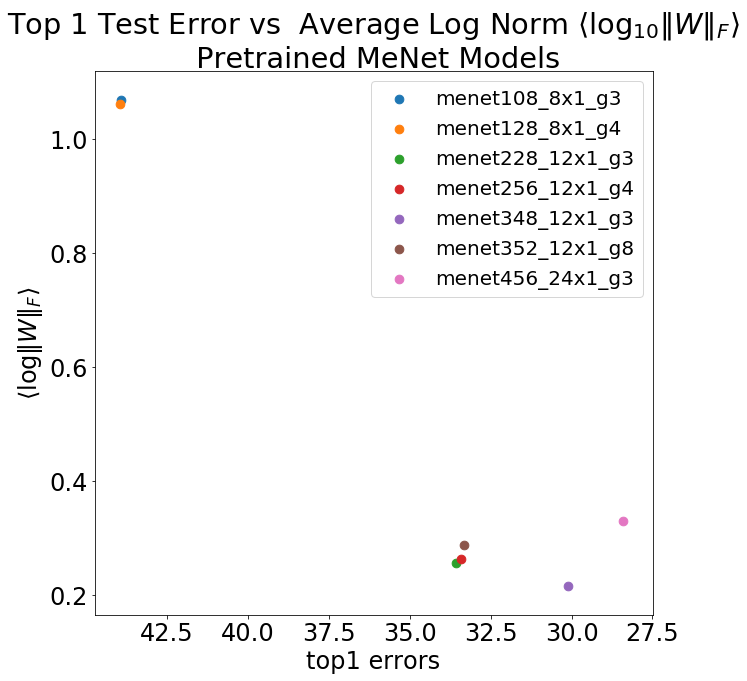

In [101]:
plot_top_errors(title="MeNet")

### ResNet

& resnet10 & 37.46 & 0.8798477053642273 \\
& resnet12 & 36.18 & 0.6783980131149292 \\
& resnet14 & 33.17 & 0.8383921384811401 \\
& resnet16 & 30.9 & 0.8271889090538025 \\
& resnet18\_wd4 & 49.5 & 0.6381021738052368 \\
& resnet18\_wd2 & 37.04 & 0.7617139220237732 \\
& resnet18\_w3d4 & 33.61 & 0.574541449546814 \\
& resnet18 & 29.52 & 0.7694433331489563 \\
& resnet34 & 25.66 & 0.5906298756599426 \\
& resnet50 & 23.79 & 0.6336358189582825 \\
& resnet50b & 23.05 & 0.6376263499259949 \\
& resnet101 & 21.9 & 0.5005567073822021 \\
& resnet101b & 21.45 & 0.5155783295631409 \\
& resnet152 & 21.26 & 0.3934951424598694 \\
& resnet152b & 20.74 & 0.4138258099555969 \\
saved img/ResNet_top1-lognorms.png


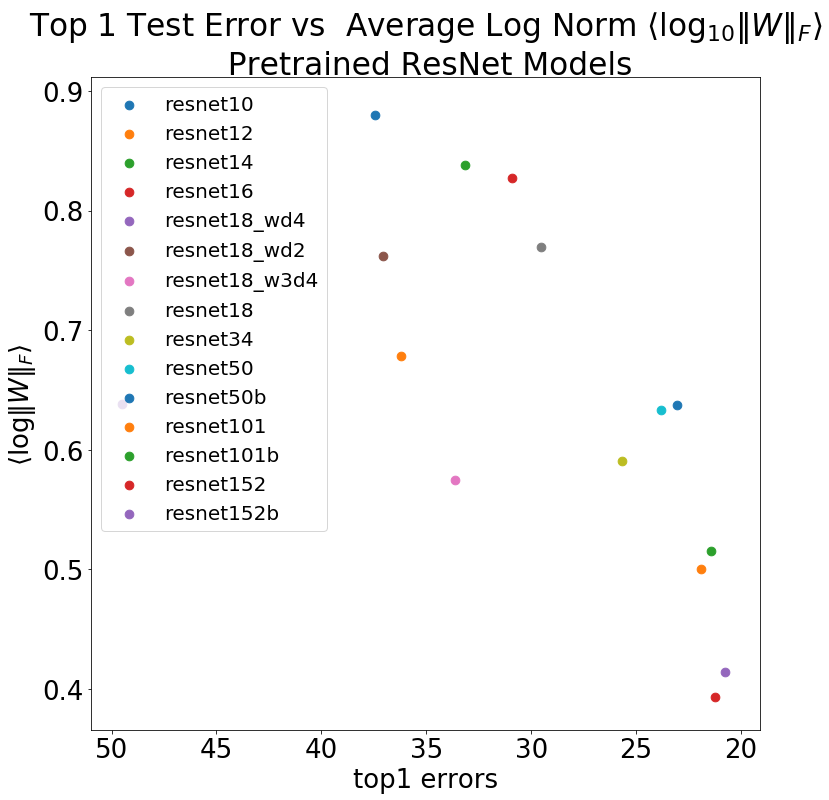

In [102]:
plot_top_errors("ResNet", small=False)

### DPN

& dpn68 & 24.17 & 0.384235143661499 \\
& dpn98 & 20.81 & 0.26446858048439026 \\
& dpn131 & 20.54 & 0.18947161734104156 \\
saved img/DPN_top1-lognorms.png


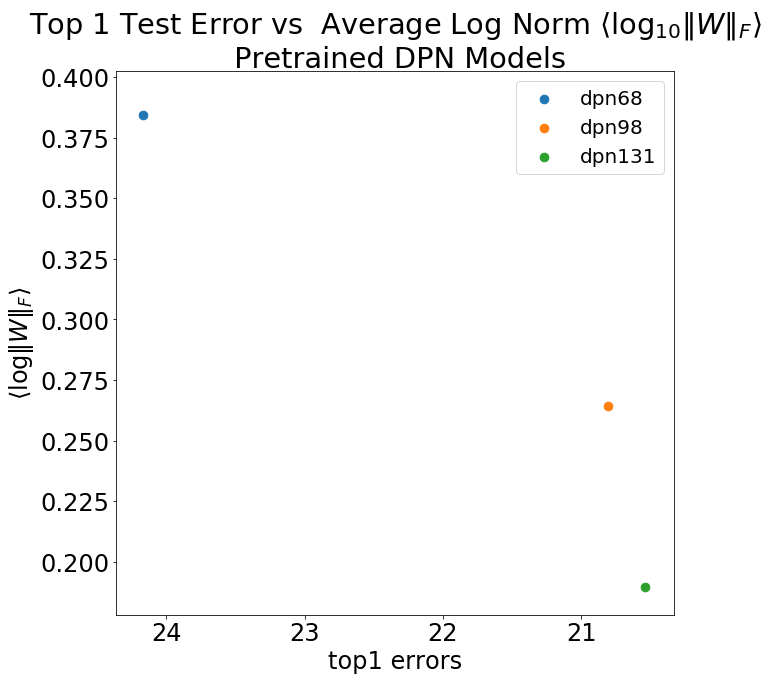

In [103]:
plot_top_errors("DPN")

### DenseNet

& densenet121 & 25.57 & 0.2602657079696655 \\
& densenet161 & 22.86 & 0.24130846560001373 \\
& densenet169 & 24.4 & 0.17591598629951477 \\
& densenet201 & 23.1 & 0.14924849569797516 \\
saved img/DenseNet_top1-lognorms.png


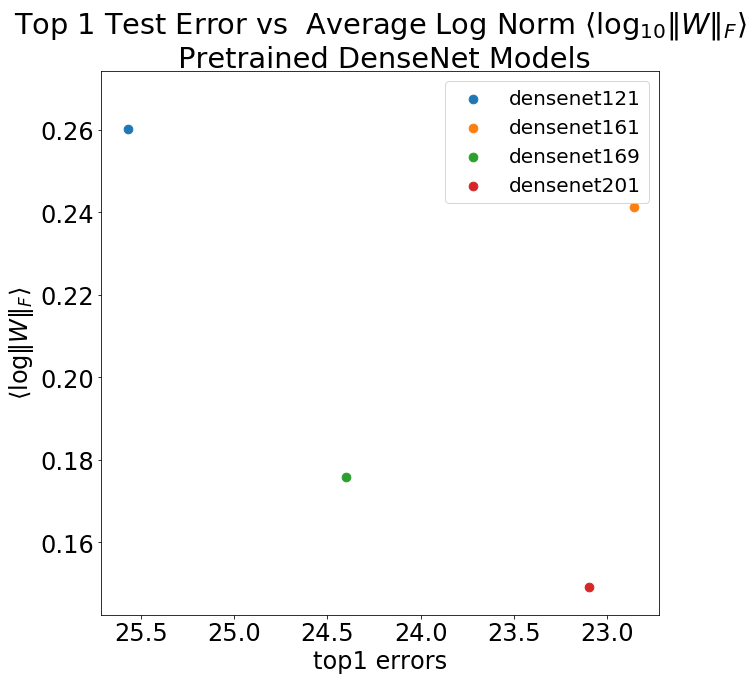

In [104]:
plot_top_errors("DenseNet")


### SeResNet

& seresnet50 & 22.47 & 0.5491737127304077 \\
& seresnet101 & 21.88 & 0.3283577561378479 \\
& seresnet152 & 21.48 & 0.1948070228099823 \\
saved img/SeResNet_top1-lognorms.png


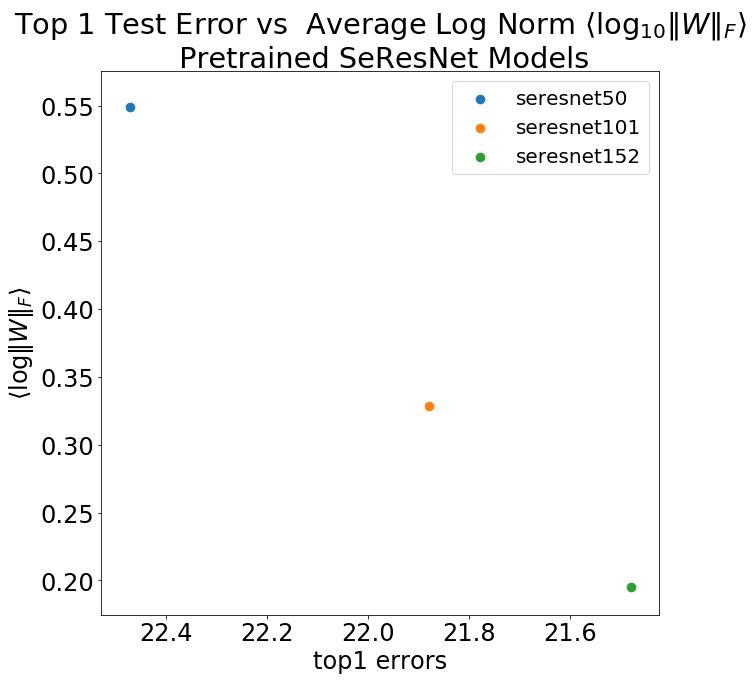

In [105]:
plot_top_errors("SeResNet")

### SeResNeXt

& seresnext50\_32x4d & 21.0 & 0.5604196190834045 \\
& seresnext101\_32x4d & 19.96 & 0.33570364117622375 \\
saved img/SeResNeXt_top1-lognorms.png


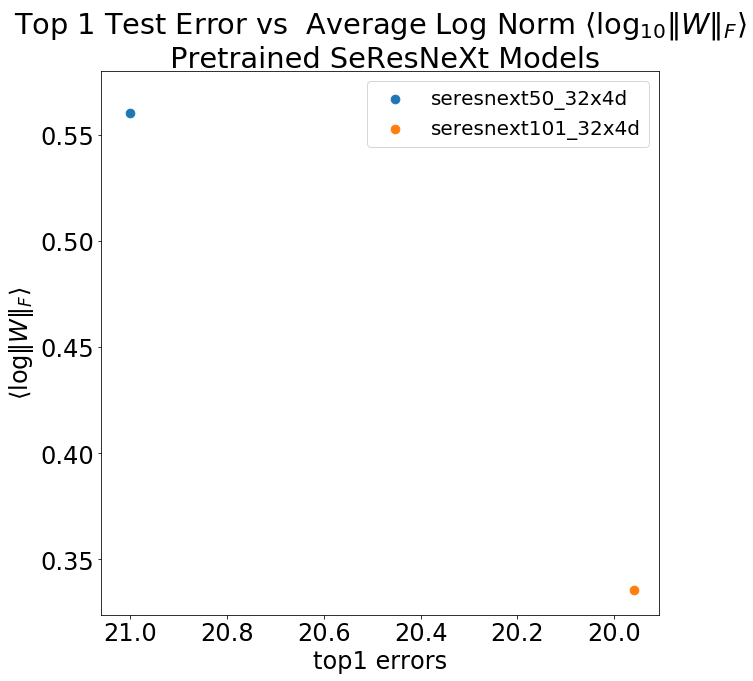

In [106]:
plot_top_errors("SeResNeXt")

& shufflenetv2\_wd2 & 41.48 & 0.9387305974960327 \\
& shufflenetv2\_w1 & 34.39 & 0.9358710050582886 \\
saved img/ShuffleNet_top1-lognorms.png


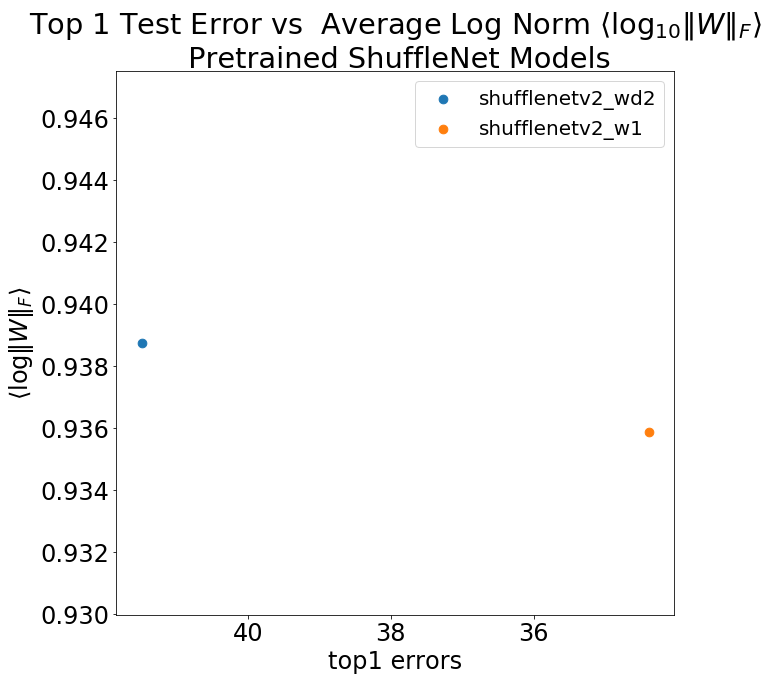

In [107]:
plot_top_errors("ShuffleNet")

## Counterexamples

- All 3 MobileNet models, which we may be interpreting incorrectly

- CondenseNet

- SqueezeNet, which different from the Pytorch defaults *(the numbers may be off)

& mobilenet\_wd4 & 46.26 & 1.2612096071243286 \\
& mobilenet\_wd2 & 36.3 & 1.1445446014404297 \\
& mobilenet\_w3d4 & 33.54 & 1.178188681602478 \\
& mobilenet\_w1 & 29.86 & 1.1933209896087646 \\
& mobilenetv2\_wd4 & 49.72 & 0.9510997533798218 \\
& mobilenetv2\_wd2 & 36.54 & 0.9513986110687256 \\
& mobilenetv2\_w3d4 & 31.89 & 0.9908249378204346 \\
& mobilenetv2\_w1 & 29.31 & 1.0258347988128662 \\
saved img/MobileNet_top1-lognorms.png


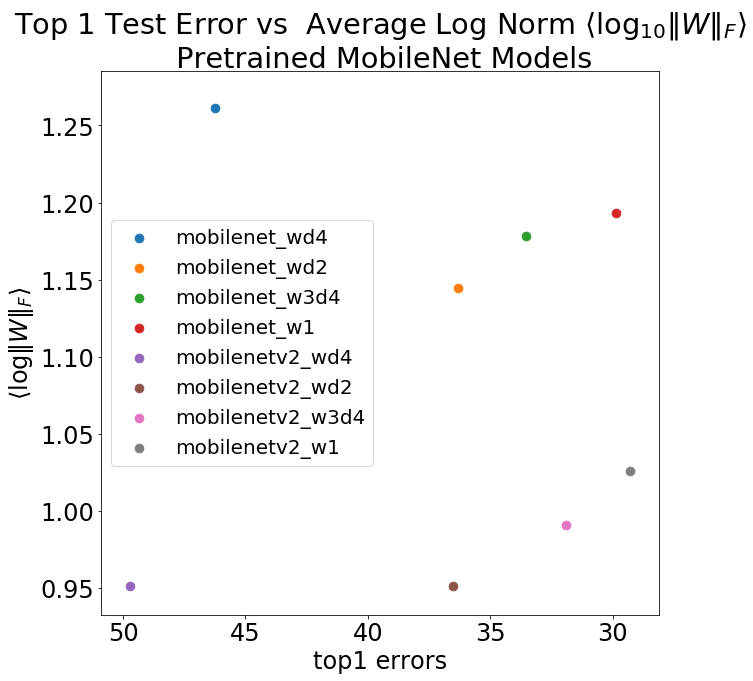

In [108]:
plot_top_errors("MobileNet")

& fdmobilenet\_wd4 & 55.77 & 1.3243149518966675 \\
& fdmobilenet\_wd2 & 43.85 & 1.3680027723312378 \\
& fdmobilenet\_w1 & 34.7 & 1.4272710084915161 \\
saved img/FDMobileNet_top1-lognorms.png


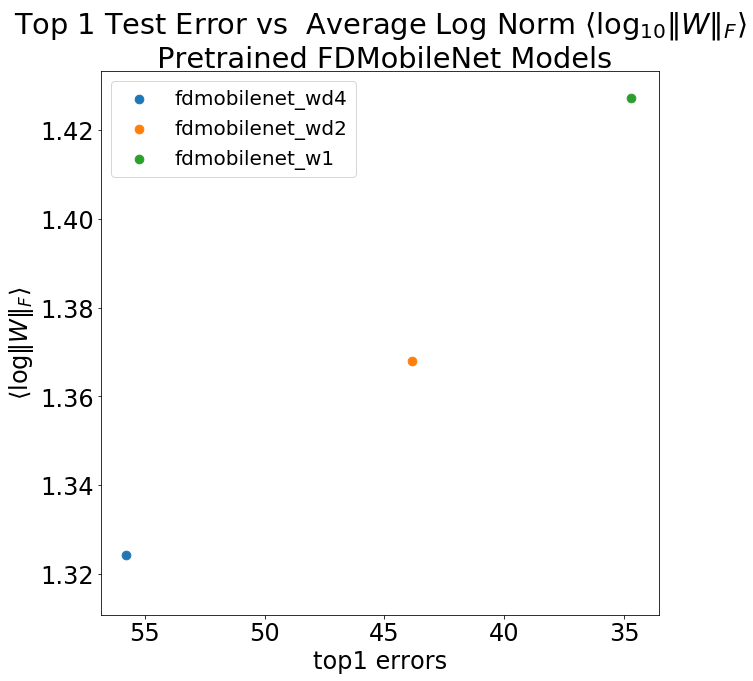

In [109]:
plot_top_errors("FDMobileNet")

###  CondenseNet is an outlier

& condensenet74\_c4\_g4 & 26.25 & 0.3231754004955292 \\
& condensenet74\_c8\_g8 & 28.93 & 0.3178260028362274 \\
saved img/CondenseNet_top1-lognorms.png


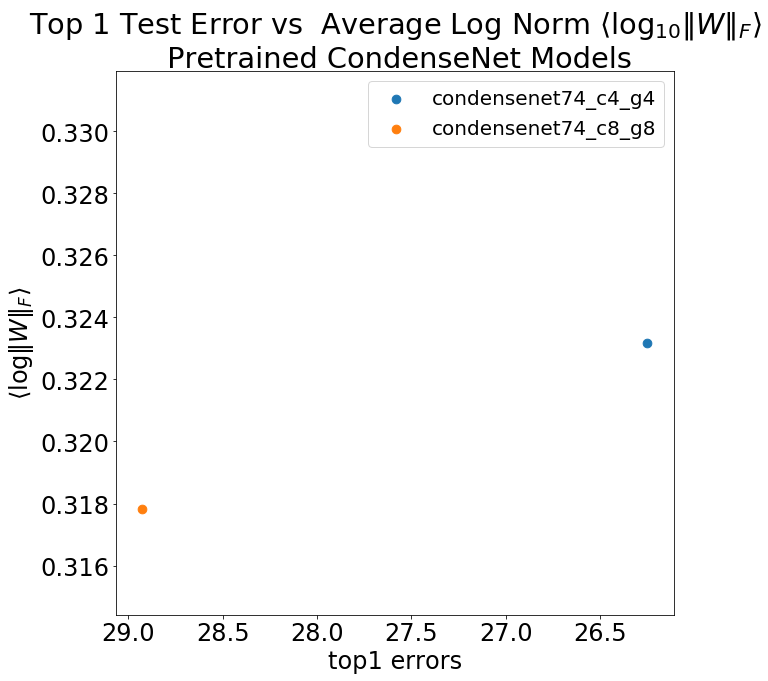

In [110]:
plot_top_errors(title="CondenseNet")

### ResNeXt

& resnext101\_32x4d & 21.81 & 0.3577885329723358 \\
& resnext101\_64x4d & 21.04 & 0.3816513419151306 \\
saved img/ResNeXt_top1-lognorms.png


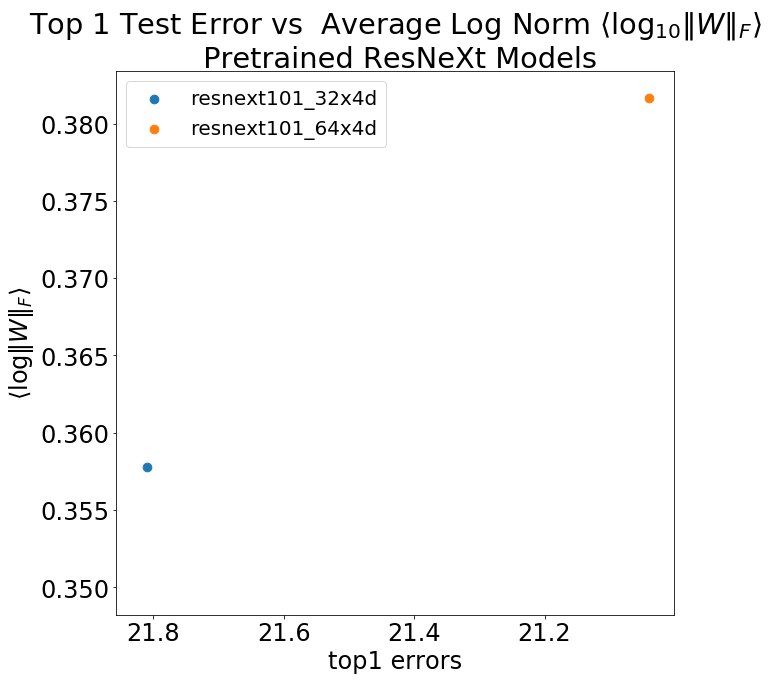

In [111]:
plot_top_errors("ResNeXt")